# Testing EOF decomposition with dask using `xeofs` package

In progress work using the `xeofs` package to analyze multi-decadal SST variability on a local machine. Data are accessed using `earthaccess` package.

Ultimately want to perform an analysis such as: https://doi.org/10.1175/2011JCLI3941.1 

Which uses the dataset: https://podaac.jpl.nasa.gov/dataset/REYNOLDS_NCDC_L4_MONTHLY_V5

Thise notebook is meant to be run as a Coiled Notebook, see docs here: https://docs.coiled.io/user_guide/usage/notebooks/index.html#notebook-file-sync 

Additional reference used for EOF analysis: https://github.com/royalosyin/Python-Practical-Application-on-Climate-Variability-Studies/blob/master/ex18-EOF%20analysis%20global%20SST.ipynb

Because the time variable in this dataset is non-conventional, the `cftime` package is required to decode the timestamps using `Xarray`.

Although the above study uses the time period 1910 to 2009, we instead use 1910 to 2008, since the data providers of the dataset changed the time format from 2008 onward and xarray doesn't like it.

## 1. Access and load MUR data

Currently need an earthaccess patch to run the `xeofs` package wish dask:

In [1]:
!pip uninstall -y earthaccess

Found existing installation: earthaccess 0.5.3
Uninstalling earthaccess-0.5.3:
  Successfully uninstalled earthaccess-0.5.3


In [2]:
!pip install -U git+https://github.com/nsidc/earthaccess.git@main

  Cloning https://github.com/nsidc/earthaccess.git (to revision main) to /tmp/pip-req-build-l2gs4cou
  Running command git clone --filter=blob:none --quiet https://github.com/nsidc/earthaccess.git /tmp/pip-req-build-l2gs4cou
  Resolved https://github.com/nsidc/earthaccess.git to commit 18f05edad5bce5441ac914804c7189dd0b0d7dde
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for earthaccess: filename=earthaccess-0.5.4-py3-none-any.whl size=54732 sha256=8f88cf84a612eab25572c359467bd2bf0b8b17454698e82f49a0819c7ec196ce
  Stored in directory: /tmp/pip-ephem-wheel-cache-wdtscwc2/wheels/a3/fb/0b/7cf7835b92c87d8ff3605bebb3d1595bd670a84e4afc24a902
Successfully built earthaccess


In [1]:
import earthaccess
import xarray as xr
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
print(earthaccess.__version__)
print(earthaccess.__file__)

0.5.3
/opt/coiled/env/lib/python3.11/site-packages/earthaccess/__init__.py


In [3]:
earthaccess.login()

EARTHDATA_USERNAME and EARTHDATA_PASSWORD are not set in the current environment, try setting them or use a different strategy (netrc, interactive)
No .netrc found in /home/mambauser


Enter your Earthdata Login username:  deanh808
Enter your Earthdata password:  ········


You're now authenticated with NASA Earthdata Login
Using token with expiration date: 10/21/2023
Using user provided credentials for EDL


In [4]:
%%time

endpoints = earthaccess.search_data(
    short_name="REYNOLDS_NCDC_L4_MONTHLY_V5",
    cloud_hosted=True,
    temporal=("1910-01-01", "2007-12-31"),
    )

Granules found: 1177
CPU times: user 154 ms, sys: 16.5 ms, total: 171 ms
Wall time: 15.4 s


In [ ]:
%%time

fileobjs = earthaccess.open(endpoints)

**Found a weird result in one of the file objects:**

In [7]:
fileobjs_bad = [f for f in fileobjs if type(f) == FileNotFoundError]
print(fileobjs_bad)

[FileNotFoundError('podaac-ops-cumulus-protected/REYNOLDS_NCDC_L4_MONTHLY_V5/ersst.v5.195908.nc.1')]


**The above file does not show up in CMR: https://cmr.earthdata.nasa.gov/virtual-directory/collections/C2036878116-POCLOUD/temporal**

This is worth looking into, but for now just remove this object from the list and continue:

In [8]:
fileobjs_good = [f for f in fileobjs if type(f) != FileNotFoundError]

In [9]:
print(len(fileobjs))
print(len(fileobjs_good))

1177
1176


#### **Can runtime of the below line be decreased using parallelization?**

In [10]:
%%time

#sstdata = xr.open_mfdataset(fileobjs_good, chunks={})
sstdata = xr.open_mfdataset(fileobjs_good[:200], chunks={})

CPU times: user 6.32 s, sys: 136 ms, total: 6.45 s
Wall time: 35.3 s


In [11]:
sstdata = sstdata.squeeze()
sstdata

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 200)
Coordinates:
  * lat      (lat) float64 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
    lev      float64 0.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) object 1909-12-01 00:00:00 ... 1926-07-01 00:00:00
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(1, 89, 180), meta=np.ndarray>
    ssta     (time, lat, lon) float32 dask.array<chunksize=(1, 89, 180), meta=np.ndarray>
Attributes: (12/38)
    Conventions:                CF-1.6, ACDD-1.3
    metadata_link:              https://doi.org/10.7289/V5T72FNM
    id:                         ersst.v5.190912
    naming_authority:           gov.noaa.ncei
    title:                      NOAA ERSSTv5 (in situ only)
    summary:                    ERSST.v5 is developped based on v4 after revi...
    ...                         ...
    platform:                   Ship and Buoy SSTs from ICOADS R3.0 and NCEP GTS
    instrument:                 Conventional thermometers
    source:                     In situ data: ICOADS R3.0 before 2015, NCEP i...
    comment:                    SSTs were observed by conventional thermomete...
    references:                 Huang et al, 2017: Extended Reconstructed Sea...
    climatology:                Climatology is based on 1971-2000 SST, Xue, Y...

## 2. Detrend and Remove Seasonal Cycle

### 2.1 Linear Detrend

Options:
* scipy.signal.detrend()
* ...

In [1]:
# xr.apply_ufunc(
#     np.nanmean, sst, 
#     input_core_dims=[['lat','lon']], 
#     #output_core_dims=[['lat']],
#     kwargs={"axis": (1,2)},
#     dask='allowed').compute()

In [12]:
# from scipy.stats import linregress

**For each lat, lon gridpoint, the data across all timestamps are either (1) all nan's or (2) no nan's. The following code verifies this:**

In [13]:
n_null = sstdata['sst'].isnull().sum(axis=0).compute().values.flatten()

In [18]:
n0 = (n_null == 0).sum() # Either no NANs
n200 = (n_null == 200).sum() # Or all NANs
len(n_null) == (n0 + n200) # True if all gridpoints contain either all or no NANs.

True

**Because the data have nan's in this way, the following linear detrend method is used (scipy.signal.detrend cannot handle nan's):**

In [60]:
nt, nlat, nlon = sstdata['sst'].shape
x = np.arange(nt)
sst_detrend = sstdata['sst'].values.reshape(nt, nlat*nlon)

In [61]:
fitresults = np.polyfit(x, sstdata['sst'].values.reshape(nt, nlat*nlon), 1, rcond=None, full=False, w=None, cov=False)
print(sst_detrend.shape)
print(fitresults[1].shape)

(200, 16020)
(16020,)


In [62]:
lintrend = sst_detrend*fitresults[0] + fitresults[1] 
lintrend.shape

(200, 16020)

In [63]:
test = sst_detrend - lintrend

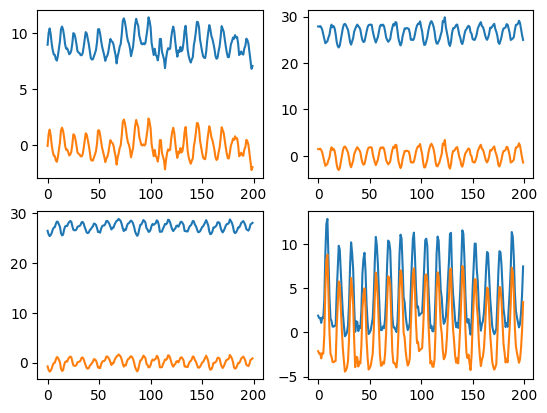

In [64]:
# Confirm detrend:
fig1, axes1 = plt.subplots(2, 2)
for ax, idx in zip(axes1.flatten(), [3500, 6500, 9500, 12500]):
    ax.plot(sst_detrend[:,idx])
    ax.plot(test[:,idx])

In [ ]:
plt.contourf(sstdata['lon'], sstdata['lat'], test.reshape((nt, nlat, nlon), order='C')[0, ...])
plt.colorbar()

In [ ]:
sst_detrend = test

**Extra code, playing around with other methods for linear detrending**

In [65]:
# sst_point = sstdata['sst'].values[:, 0, 0]
# x = np.arange(len(sst_point))
# results = linregress(x=x, y=sst_point, alternative='two-sided')
# results

In [66]:
#sst_point_fit = x*results.slope + results.intercept

In [67]:
# #sst_point_detrend = signal.detrend(sst_point, axis=0, type='linear', bp=0)
# sst_point_detrend = sst_point - sst_point_fit

In [68]:
# ...
#sst_detrend = signal.detrend(sst, axis=0, type='linear', bp=0)

### 2.2 Remove Seasonal Cycle

In [ ]:
test = sst_detrend.reshape((12, int(nt_temp/12), nlat, nlon), order='F')

In [ ]:
xdummy =np.arange(1,13)

plt.figure()
for i in range(10):
    plt.scatter(xdummy, test[:, i, 60, 150])

In [69]:
#sst.apply_ufunc(np.reshape(nt, nlat*nlon))

In [70]:
r = nt % 12

if r == 0:
    nt_temp = nt
else:
    nanpad = np.ones([12-r, nlat*nlon])*np.nan
    nt_temp = nt + (12-r)
    sst_detrend = np.append(sst_detrend, nanpad, axis=0)

In [71]:
#ssttest = sst.reshape((12, int(nt/12), nlat, nlon), order='F')
sst_detrend = sst_detrend.reshape((12, int(nt_temp/12), nlat, nlon), order='F').transpose((1,0,2,3))

In [72]:
sst_seasonal = sst_detrend.mean(axis=0)

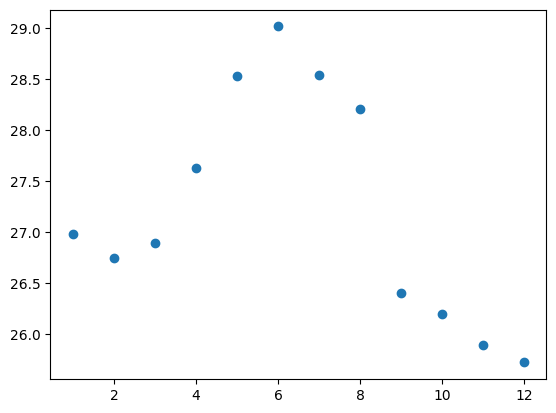

In [73]:
plt.scatter(np.arange(1,13), sst_seasonal[:, 50, 100])

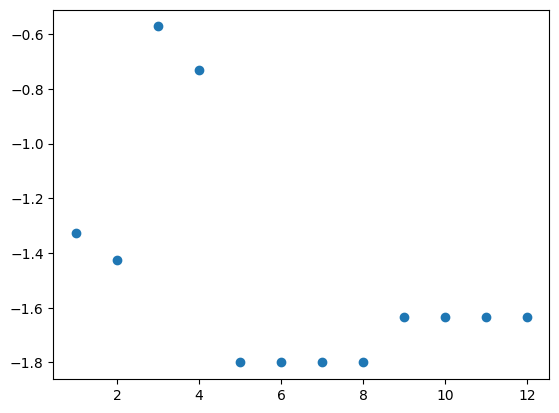

In [74]:
plt.scatter(np.arange(1,13), sst_seasonal[:, 20, 20])

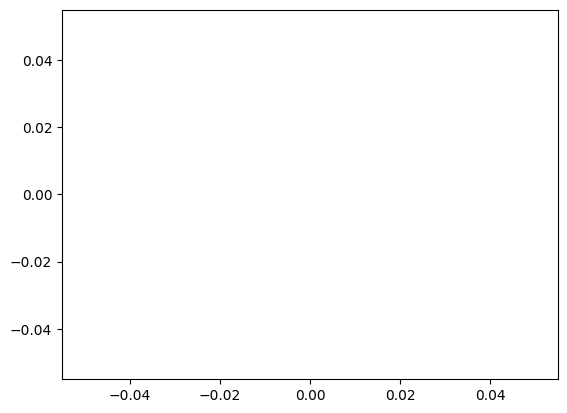

In [75]:
plt.scatter(np.arange(1,13), sst_seasonal[:, 60, 90])

In [76]:
sst_detrend = sst_detrend - sst_seasonal

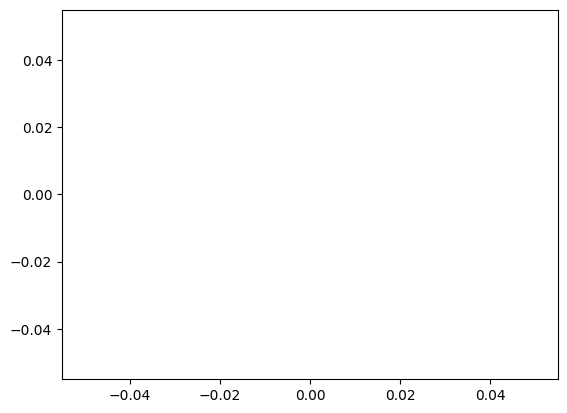

In [77]:
plt.scatter(np.arange(1,13), sst_detrend[2, :, 60, 90])

In [78]:
sst_detrend.shape

(17, 12, 89, 180)

In [81]:
#sstdata['sst'].values = sst_detrend.reshape(nt, nlat, nlon)

In [82]:
sst_detrend = sst_detrend.reshape(nt, nlat, nlon)

In [ ]:
sst_detrend_xa = xr.DataArray(
    data=sst_detrend,
    dims=['time', 'lat', 'lon'],
    coords=dict(
        lon=sstdata['lon'],
        lat=sstdata['lat'],
        time=sstdata['time']
    ),
    #attrs=dict(
    #    description="Ambient temperature.",
    #    units="degC",
    #),
)

In [ ]:
test = sst_detrend[:nt, ...]

In [ ]:
test.shape

In [ ]:
plt.contourf(sstdata['lon'], sstdata['lat'], test[0, ...])
plt.colorbar()

## 3. EOF decomp

In [80]:
import xeofs as xe

In [83]:
%%time

model = xe.models.EOF(n_modes=10)
#model.fit(sstdata['sst'], dim='time')
model.fit(sst_detrend, dim='time')

TypeError: Invalid input type: ndarray. Expected one of of the following: DataArray, Dataset or list of DataArrays.

In [87]:
%%time

model.explained_variance_ratio().load()

CPU times: user 595 µs, sys: 23 µs, total: 618 µs
Wall time: 623 µs


<xarray.DataArray 'explained_variance_ratio' (mode: 10)>
array([0.16010585, 0.08270313, 0.04050591, 0.02948759, 0.02791131,
       0.02421382, 0.02226832, 0.02088284, 0.01971043, 0.01908684],
      dtype=float32)
Coordinates:
    lev      float64 0.0
  * mode     (mode) int64 1 2 3 4 5 6 7 8 9 10
Attributes:
    model:        EOF analysis
    n_modes:      10
    standardize:  False
    use_coslat:   False
    use_weights:  False
    solver:       auto
    software:     xeofs
    version:      1.1.0
    date:         2023-09-20 17:09:37

In [88]:
%%time

components = model.components().load()

CPU times: user 3.22 ms, sys: 39 µs, total: 3.26 ms
Wall time: 2.79 ms


In [89]:
components

<xarray.DataArray 'components' (mode: 10, lat: 83, lon: 180)>
array([[[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [-0.0000000e+00, -0.0000000e+00, -0.0000000e+00, ...,
          1.7255982e-08, -0.0000000e+00, -0.0000000e+00],
        [-0.0000000e+00, -0.0000000e+00, -0.0000000e+00, ...,
         -0.0000000e+00, -0.0000000e+00, -0.0000000e+00],
        [-0.0000000e+00, -0.0000000e+00, -0.0000000e+00, ...,
         -0.0000000e+00, -0.0000000e+00, -0.0000000e+00]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
...
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          1.4329502e-08,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         -4.9433542e-09,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -76.0 -74.0 -72.0 -70.0 -68.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
    lev      float64 0.0
  * mode     (mode) int64 1 2 3 4 5 6 7 8 9 10
Attributes:
    model:        EOF analysis
    n_modes:      10
    standardize:  False
    use_coslat:   False
    use_weights:  False
    solver:       auto
    software:     xeofs
    version:      1.1.0
    date:         2023-09-20 17:09:37

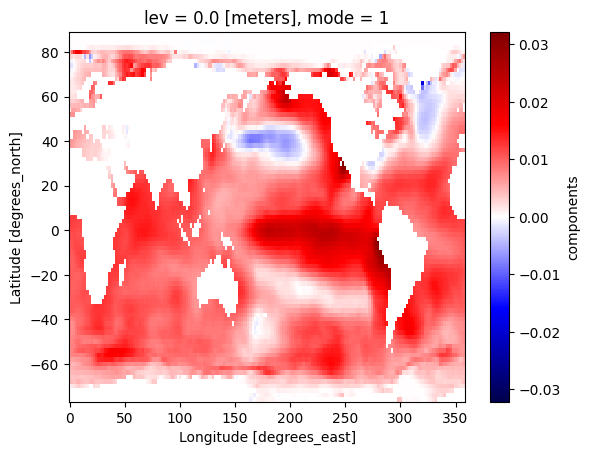

In [90]:
components.sel(mode=1).plot(cmap='seismic')

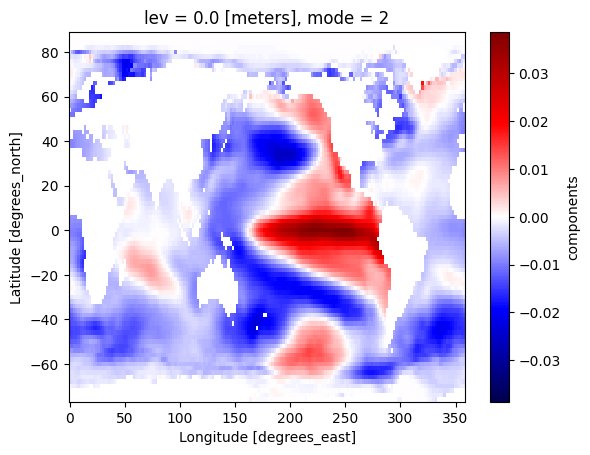

In [91]:
components.sel(mode=2).plot(cmap='seismic')

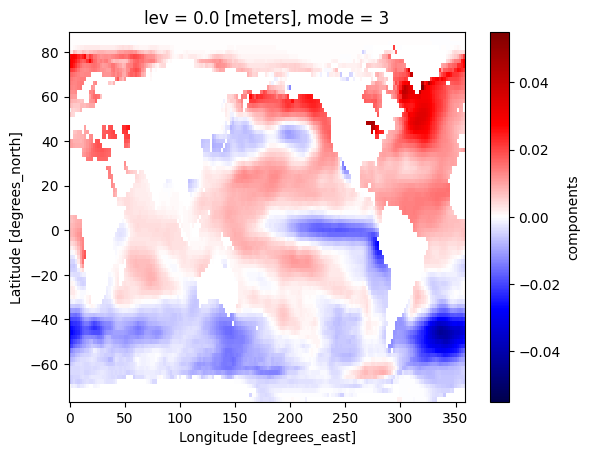

In [103]:
components.sel(mode=3).plot(cmap='seismic')

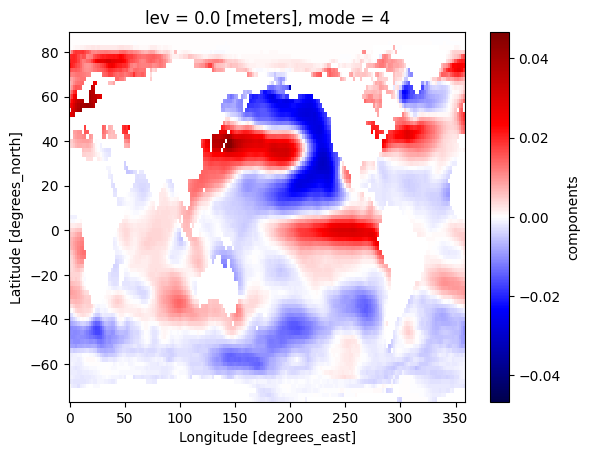

In [93]:
components.sel(mode=4).plot(cmap='seismic')

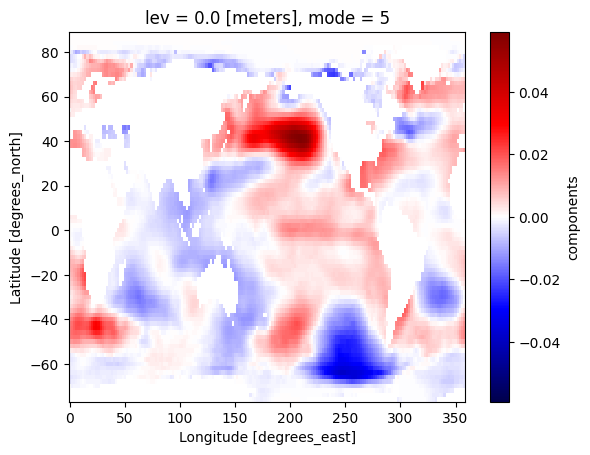

In [105]:
components.sel(mode=5).plot(cmap='seismic')

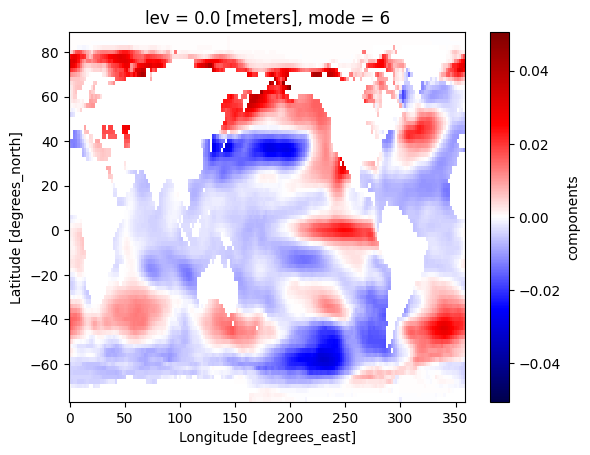

In [95]:
components.sel(mode=6).plot(cmap='seismic')

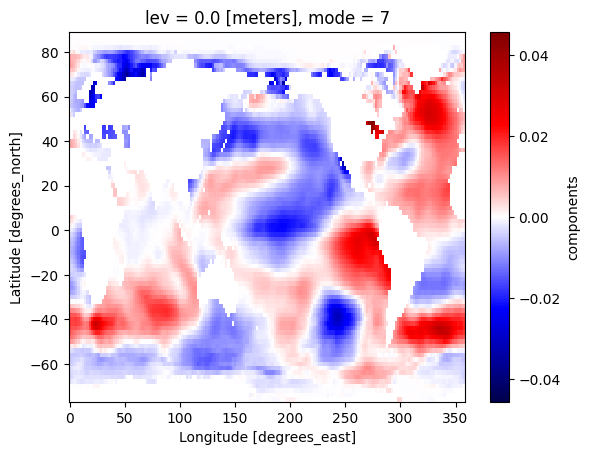

In [96]:
components.sel(mode=7).plot(cmap='seismic')

In [97]:
%%time

scores = model.scores().load()

CPU times: user 557 µs, sys: 22 µs, total: 579 µs
Wall time: 584 µs


In [98]:
scores

<xarray.DataArray 'scores' (mode: 10, time: 1176)>
array([[-0.06969926, -0.06111296, -0.06134666, ...,  0.02612345,
         0.01730099,  0.01170032],
       [-0.02736687, -0.02628703, -0.02107777, ..., -0.05522644,
        -0.06508312, -0.06237767],
       [-0.01092567, -0.01824391, -0.01680522, ...,  0.05718492,
         0.04887183,  0.04403059],
       ...,
       [ 0.03523493,  0.02922515,  0.02681626, ...,  0.03497196,
         0.02230215,  0.00723828],
       [ 0.00146582,  0.00431154,  0.00946791, ...,  0.00879413,
         0.01135814,  0.00970706],
       [-0.0168312 , -0.03307635, -0.00236932, ..., -0.00558044,
        -0.0146097 , -0.00540318]], dtype=float32)
Coordinates:
    lev      float64 0.0
  * time     (time) object 1909-12-01 00:00:00 ... 2007-11-01 00:00:00
  * mode     (mode) int64 1 2 3 4 5 6 7 8 9 10
Attributes:
    model:        EOF analysis
    n_modes:      10
    standardize:  False
    use_coslat:   False
    use_weights:  False
    solver:       auto
    software:     xeofs
    version:      1.1.0
    date:         2023-09-20 17:09:37

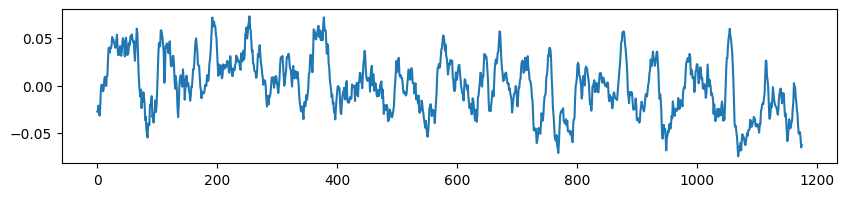

In [102]:
plt.figure(figsize=(10,2))
plt.plot(scores.sel(mode=2).values)

ImportError: Plotting of arrays of cftime.datetime objects or arrays indexed by cftime.datetime objects requires the optional `nc-time-axis` (v1.2.0 or later) package.

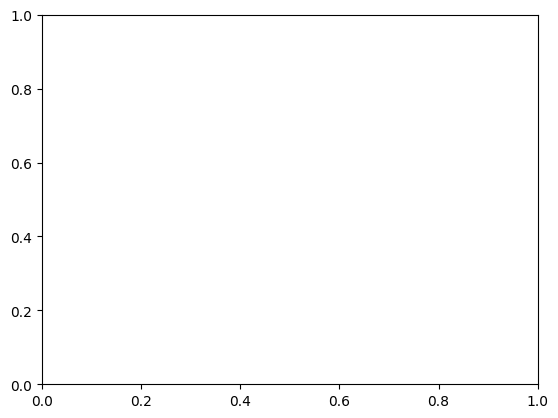

In [49]:
scores.sel(mode=1).plot()

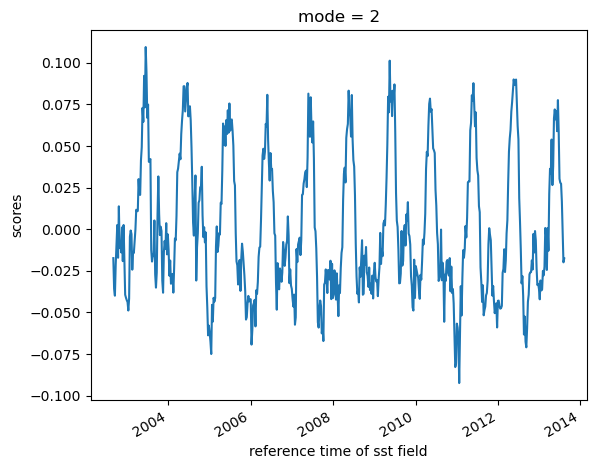

In [19]:
scores.sel(mode=2).plot()

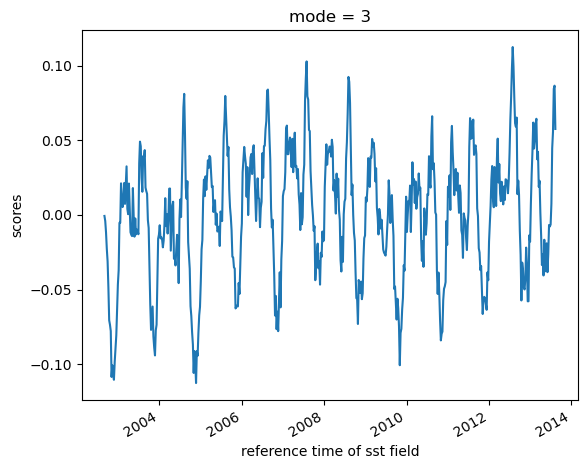

In [25]:
scores.sel(mode=3).plot()

## 4. EOF decomp with Dask

In [28]:
import coiled

In [29]:
cluster = coiled.Cluster(n_workers=10, region='us-west-2')

Output()

Package - coiled_local_working, Built wheel does not contain all python files!

╭────────────────────────────────────────── Package Info ──────────────────────────────────────────╮
│                        ╷                                                                         │
│   Package              │ Note                                                                    │
│ ╶──────────────────────┼───────────────────────────────────────────────────────────────────────╴ │
│   coiled_local_synced  │ Source wheel built from /scratch/synced                                 │
│   coiled_local_working │ Source wheel built from                                                 │
│                        │ /opt/coiled/rt/.path-deps/coiled_local_working-0.0.0-py3-none-any.whl   │
│                        ╵                                                                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────── Not Synced with Cluster ─────────────────────────────────────╮
│                            ╷                                                        ╷            │
│   Package                  │ Error                                                  │ Risk       │
│ ╶──────────────────────────┼────────────────────────────────────────────────────────┼──────────╴ │
│   coiled_local_working     │ Built wheel does not contain all python files!         │ Warning    │
│                            ╵                                                        ╵            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

Output()

In [30]:
client = cluster.get_client()

In [31]:
client

<Client: 'tls://10.0.53.154:8786' processes=10 threads=40, memory=148.38 GiB>

In [40]:
client.shutdown()

In [11]:
from dask.distributed import Client, LocalCluster

In [12]:
client = Client()

In [13]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: https://cluster-cpnwk.dask.host/jupyter/proxy/8787/status,
Dashboard: https://cluster-cpnwk.dask.host/jupyter/proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 14.84 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38015,Workers: 4
Dashboard: https://cluster-cpnwk.dask.host/jupyter/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 14.84 GiB
Comm: tcp://127.0.0.1:45299,Total threads: 1
Dashboard: https://cluster-cpnwk.dask.host/jupyter/proxy/39635/status,Memory: 3.71 GiB
Nanny: tcp://127.0.0.1:41045,


In [15]:
import xeofs as xe

In [19]:
sstdata['ssta'].mean().load()

/opt/coiled/env/lib/python3.11/site-packages/distributed/client.py:3160: UserWarning: Sending large graph of size 120.89 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
Exception ignored in: <function CachingFileManager.__del__ at 0x7f6943b90d60>
Traceback (most recent call last):
  File "/opt/coiled/env/lib/python3.11/site-packages/xarray/backends/file_manager.py", line 244, in __del__
    ref_count = self._ref_counter.decrement(self._key)
                ^^^^^^^^^^^^^^^^^
AttributeError: 'CachingFileManager' object has no attribute '_ref_counter'


RuntimeError: Error during deserialization of the task graph. This frequently occurs if the Scheduler and Client have different environments. For more information, see https://docs.dask.org/en/stable/deployment-considerations.html#consistent-software-environments


In [16]:
model = xe.models.EOF(n_modes=10)
model.fit(sstdata['ssta'], dim='time')

/opt/coiled/env/lib/python3.11/site-packages/distributed/client.py:3160: UserWarning: Sending large graph of size 120.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
Exception ignored in: <function CachingFileManager.__del__ at 0x7f6943b90d60>
Traceback (most recent call last):
  File "/opt/coiled/env/lib/python3.11/site-packages/xarray/backends/file_manager.py", line 244, in __del__
    ref_count = self._ref_counter.decrement(self._key)
                ^^^^^^^^^^^^^^^^^
AttributeError: 'CachingFileManager' object has no attribute '_ref_counter'


RuntimeError: Error during deserialization of the task graph. This frequently occurs if the Scheduler and Client have different environments. For more information, see https://docs.dask.org/en/stable/deployment-considerations.html#consistent-software-environments


In [35]:
evr = model.explained_variance_ratio()

In [36]:
evr

<xarray.DataArray 'explained_variance_ratio' (mode: 10)>
array([0.16010582, 0.08270313, 0.04050592, 0.02948766, 0.02791134,
       0.02421374, 0.02226816, 0.02088275, 0.01971089, 0.01908752],
      dtype=float32)
Coordinates:
    lev      float64 0.0
  * mode     (mode) int64 1 2 3 4 5 6 7 8 9 10
Attributes:
    model:        EOF analysis
    n_modes:      10
    standardize:  False
    use_coslat:   False
    use_weights:  False
    solver:       auto
    software:     xeofs
    version:      1.1.0
    date:         2023-09-14 20:54:42

In [38]:
sstdata['ssta']

<xarray.DataArray 'ssta' (time: 1176, lat: 89, lon: 180)>
dask.array<getitem, shape=(1176, 89, 180), dtype=float32, chunksize=(1, 89, 180), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
    lev      float64 0.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) object 1909-12-01 00:00:00 ... 2007-11-01 00:00:00
Attributes:
    long_name:  Extended reconstructed SST anomalies
    units:      degree_C
    valid_min:  -12.0
    valid_max:  12.0

## Appendix A: checking for nan's in the dataset

!This section reloads the data!

In [ ]:
sstdata = xr.open_mfdataset(fileobjs_good, chunks={})

In [ ]:
sstdata = sstdata.squeeze()
sst = sstdata['sst'].values

In [68]:
anan = []
for i in range(sst.shape[0]):
    anan.append(np.argwhere(np.isnan(sst)[i]).shape)

In [74]:
anan[0]

(3952, 2)

In [69]:
print(anan[0] == anan[1])

True


In [70]:
for a in anan:
    if a != anan[0]:
        print('flag!')